# Transfer Learning - Flower Classification

In [1]:
%pip install torch
%pip install torchvision
%pip install scipy 
%pip install torchsummary
%pip install tqdm 
%pip install opencv-python
%pip install albumentations==0.4.6

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 750.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=3cffa2092159a2e66ca1f87707d6c7b38651944eb40286b389d781f0e8a02a89
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.1.0
    Uninstalling albumentations-1.1.0:
      Successfully uninstalled albument

In [2]:
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
import glob
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
import albumentations as A  
from functools import cmp_to_key
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
import torchvision.models as models
from torchvision.io import read_image
from torchsummary import summary 
import matplotlib.pyplot as plt
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import tarfile
import json
import scipy.io

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

## Exatract images for dataset

In [4]:
#simple function to extract the train data
#tar_file : the path to the .tar file
#path : the path where it will be extracted
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)
     
    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")
extract('../input/flowers/102flowers.tgz','./')

## Load Data

In [5]:
labels = scipy.io.loadmat('../input/flowers/imagelabels.mat.txt')['labels'][0]
imgs_path = glob.glob("./jpg/*")

### Sort For Easy Excess

In [6]:
def cmp_file_names(item1, item2):
    item1 = int(item1.split("_")[1].replace('.jpg',''))
    item2 = int(item2.split("_")[1].replace('.jpg',''))   
    return item1 - item2
imgs_path = np.array(sorted(imgs_path,key=cmp_to_key(cmp_file_names)))
labels = np.array(labels)

### Combine Path & labels

In [7]:
def divide_train_test_split(test_size=0.25,val_size=0.25):
    X_train, X_test, y_train, y_test = train_test_split(imgs_path, labels, test_size=test_size, random_state=1)
    val_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=1) 
    return {
        'train': (X_train,y_train),
        'validation': (X_val,y_val),
        'test': (X_test,y_test),
    }
divide_train_test_split()

{'train': (array(['./jpg/image_06462.jpg', './jpg/image_04103.jpg',
         './jpg/image_02324.jpg', ..., './jpg/image_04255.jpg',
         './jpg/image_00974.jpg', './jpg/image_03638.jpg'], dtype='<U21'),
  array([33, 29, 43, ..., 18, 46, 72], dtype=uint8)),
 'validation': (array(['./jpg/image_04100.jpg', './jpg/image_06602.jpg',
         './jpg/image_03642.jpg', ..., './jpg/image_05294.jpg',
         './jpg/image_06449.jpg', './jpg/image_04543.jpg'], dtype='<U21'),
  array([29, 25, 53, ..., 70, 33, 71], dtype=uint8)),
 'test': (array(['./jpg/image_03892.jpg', './jpg/image_06722.jpg',
         './jpg/image_03415.jpg', ..., './jpg/image_04550.jpg',
         './jpg/image_06489.jpg', './jpg/image_04493.jpg'], dtype='<U21'),
  array([17, 79, 23, ..., 71, 26, 71], dtype=uint8))}

## Import Pretrained Model

In [8]:
N_CLASS = 102

### Set Last layer as final tunning 

In [9]:
def init_by_name(name):
    if name is 'vgg':
        model = models.vgg16(pretrained=True)
    elif name is 'resnet':
        model = models.resnet50(pretrained=True)
    else:
        raise ValueError("need right name")
    # freeze unwanted weight change
    for param in model.parameters():
        param.requires_grad = False
    # update last layer for our problem 
    if name is 'vgg':
        modelOutputFeats = model.classifier[6].in_features
        model.classifier[6] = torch.nn.Linear(modelOutputFeats, N_CLASS)
        model.softmax = torch.nn.Softmax(dim=1)
    else:
        modelOutputFeats = model.fc.in_features
        model.fc = torch.nn.Linear(modelOutputFeats, N_CLASS)
        model.softmax = torch.nn.Softmax(dim=1)
    model = model.to(device)
    return model

After building the model we should define all hyper paramters
we almost there, the only need is to import and use the data. Torch uses Dataset & DataLoader,
To do Just that! 

we need to create the data loader each time for diffrent eval & test for each epoch

In [10]:
def create_data_splits(transform):
    data_dict = divide_train_test_split()
    new_dict = dict()
    for key,val in data_dict.items():
        ds = ImgeDataset(val,transform)
        new_dict[key] = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
    return new_dict

In [11]:
from PIL import Image
class ImgeDataset(Dataset):
    
    def __init__(self, data_tuple, transform):
        self.imgs_path, self.labels = data_tuple
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def _pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    
    def __getitem__(self, idx):
        image = self._pil_loader(self.imgs_path[idx])
        if self.transform:
            image = self.transform(image)
        label = torch.zeros((N_CLASS))
        label[self.labels[idx]-1] = 1
        return image.to(device), label.to(device)

In [12]:
# Image transformations
data_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

glob_loader = create_data_splits(data_transforms)

## Plot The Test Data

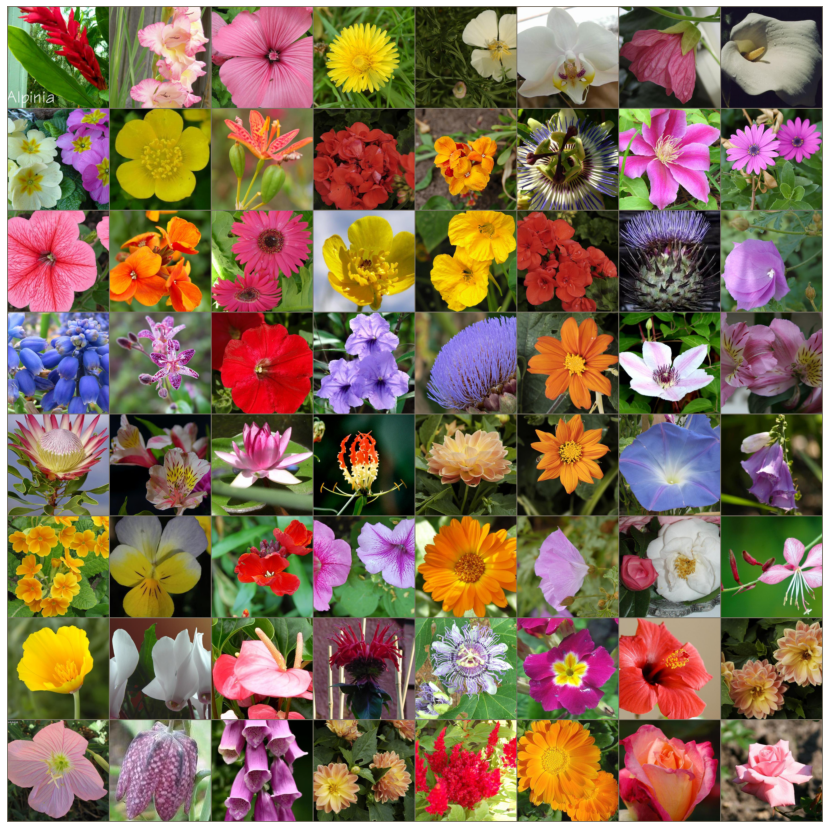

In [13]:
def imshow(image):
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy().transpose((1, 2, 0))
    else:
        image = np.array(image).transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plt.imshow(image)
    ax.axis('off') 
        
    # Make a grid from batch
images, _ = next(iter(glob_loader['test']))
out = torchvision.utils.make_grid(images, nrow=8)
imshow(out)

In [14]:
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    labels = torch.argmax(labels,dim=1)
    return torch.sum(preds==labels).item()

## Epoches

In [15]:
def train_epoch(loader,model,optimizer,criterion):
    model.train()
    running_loss = 0.
    runnning_acc = .0
    for inputs, labels in loader:
        optimizer.zero_grad()
        preds = model(inputs)
        runnning_acc += accuracy(preds,labels)
        loss = criterion(preds, labels)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    return running_loss, 100 * (runnning_acc/len(loader.dataset))

In [16]:
def validation_epoch(loader,model,criterion):
    model.eval()
    running_loss = 0
    runnning_acc = 0
    for inputs, labels in loader: 
        preds = model(inputs)
        runnning_acc += accuracy(preds,labels)
        loss = criterion(preds, labels)
        running_loss += loss.item()
    return running_loss, 100 * (runnning_acc/len(loader.dataset))

In [17]:
def runner(gloab_loader,model_name,epoch_num=10,run_num=2):
    saver = []
    for run_idx in range(run_num):
        model = init_by_name(model_name)
        print(f"####  N.{run_idx}  ####")
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = torch.nn.CrossEntropyLoss()

        meta_by_epoch = {
            'train': { 'loss': [],"accuracy": []},
            'validation': { 'loss': [], 'accuracy': []},
            'test': { 'loss': [], 'accuracy': []},
            
        }
        for ep in tqdm(range(epoch_num)):
            train_loss, train_acc = train_epoch(gloab_loader['train'],model,optimizer,criterion)
            meta_by_epoch['train']['loss'].append(train_loss)
            meta_by_epoch['train']['accuracy'].append(train_acc)
            val_loss, val_acc = validation_epoch(gloab_loader['validation'],model,criterion)
            meta_by_epoch['validation']['loss'].append(val_loss)
            meta_by_epoch['validation']['accuracy'].append(val_acc)
            print(f"Epoch N.{ep}: Train loss: {train_loss}, Validation Acc: {val_acc} ")
        test_loss, test_acc = validation_epoch(gloab_loader['test'],model,criterion)
        meta_by_epoch['test']['loss'].append(test_loss)
        meta_by_epoch['test']['accuracy'].append(test_acc)
        print(f"Epoch N.{ep}: Test Acc: {test_acc} ")
        saver.append(meta_by_epoch)
    return saver

In [18]:
vgg_meta = runner(glob_loader,'vgg')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

####  N.0  ####


 10%|█         | 1/10 [01:13<11:00, 73.33s/it]

Epoch N.0: Train loss: 261.75234174728394, Validation Acc: 34.929164631167566 


 20%|██        | 2/10 [02:20<09:18, 69.81s/it]

Epoch N.1: Train loss: 189.0138590335846, Validation Acc: 53.44406448461163 


 30%|███       | 3/10 [03:28<08:01, 68.79s/it]

Epoch N.2: Train loss: 147.62049996852875, Validation Acc: 62.188568637029796 


 40%|████      | 4/10 [04:35<06:49, 68.24s/it]

Epoch N.3: Train loss: 124.17147779464722, Validation Acc: 68.44162188568636 


 50%|█████     | 5/10 [05:42<05:39, 67.86s/it]

Epoch N.4: Train loss: 107.0021401643753, Validation Acc: 71.71470444553005 


 60%|██████    | 6/10 [06:49<04:30, 67.50s/it]

Epoch N.5: Train loss: 95.21720170974731, Validation Acc: 73.71763556424035 


 70%|███████   | 7/10 [07:56<03:21, 67.29s/it]

Epoch N.6: Train loss: 86.68759620189667, Validation Acc: 76.30679042501221 


 80%|████████  | 8/10 [09:03<02:14, 67.08s/it]

Epoch N.7: Train loss: 78.65607404708862, Validation Acc: 77.52808988764045 


 90%|█████████ | 9/10 [10:10<01:07, 67.12s/it]

Epoch N.8: Train loss: 72.73746925592422, Validation Acc: 79.38446507083536 


100%|██████████| 10/10 [11:17<00:00, 67.76s/it]

Epoch N.9: Train loss: 68.18878960609436, Validation Acc: 79.62872496336102 


Epoch N.9: Test Acc: 80.2734375 
####  N.1  ####


 10%|█         | 1/10 [01:07<10:04, 67.12s/it]

Epoch N.0: Train loss: 261.2940618991852, Validation Acc: 36.54127992183683 


 20%|██        | 2/10 [02:14<08:59, 67.38s/it]

Epoch N.1: Train loss: 188.1629934310913, Validation Acc: 52.61358085002442 


 30%|███       | 3/10 [03:21<07:50, 67.28s/it]

Epoch N.2: Train loss: 147.84688115119934, Validation Acc: 63.65412799218368 


 40%|████      | 4/10 [04:28<06:42, 67.02s/it]

Epoch N.3: Train loss: 124.05069744586945, Validation Acc: 67.95310210063508 


 50%|█████     | 5/10 [05:35<05:34, 66.86s/it]

Epoch N.4: Train loss: 106.77847361564636, Validation Acc: 71.323888617489 


 60%|██████    | 6/10 [06:41<04:26, 66.67s/it]

Epoch N.5: Train loss: 95.17457020282745, Validation Acc: 74.74352711284807 


 70%|███████   | 7/10 [07:47<03:19, 66.58s/it]

Epoch N.6: Train loss: 86.44994497299194, Validation Acc: 76.16023448949683 


 80%|████████  | 8/10 [08:54<02:12, 66.49s/it]

Epoch N.7: Train loss: 78.60888278484344, Validation Acc: 78.74938935026869 


 90%|█████████ | 9/10 [10:00<01:06, 66.45s/it]

Epoch N.8: Train loss: 73.27956998348236, Validation Acc: 79.14020517830971 


100%|██████████| 10/10 [11:06<00:00, 66.66s/it]

Epoch N.9: Train loss: 68.10027152299881, Validation Acc: 80.16609672691743 


Epoch N.9: Test Acc: 80.126953125 


In [19]:
res_meta = runner(glob_loader,'resnet')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

####  N.0  ####


 10%|█         | 1/10 [01:02<09:18, 62.08s/it]

Epoch N.0: Train loss: 280.34305787086487, Validation Acc: 21.104054714215927 


 20%|██        | 2/10 [02:04<08:16, 62.09s/it]

Epoch N.1: Train loss: 244.4220790863037, Validation Acc: 29.995114802149487 


 30%|███       | 3/10 [03:05<07:13, 61.94s/it]

Epoch N.2: Train loss: 215.223815202713, Validation Acc: 41.866145578895946 


 40%|████      | 4/10 [04:08<06:12, 62.03s/it]

Epoch N.3: Train loss: 190.82277464866638, Validation Acc: 49.53590620420127 


 50%|█████     | 5/10 [05:09<05:09, 61.89s/it]

Epoch N.4: Train loss: 170.0627841949463, Validation Acc: 57.84074255007327 


 60%|██████    | 6/10 [06:11<04:07, 61.83s/it]

Epoch N.5: Train loss: 152.6111308336258, Validation Acc: 62.530532486565704 


 70%|███████   | 7/10 [07:14<03:06, 62.22s/it]

Epoch N.6: Train loss: 138.0583223104477, Validation Acc: 65.55935515388373 


 80%|████████  | 8/10 [08:19<02:06, 63.08s/it]

Epoch N.7: Train loss: 125.37265968322754, Validation Acc: 69.12554958475819 


 90%|█████████ | 9/10 [09:22<01:03, 63.17s/it]

Epoch N.8: Train loss: 114.93007719516754, Validation Acc: 71.66585246702492 


100%|██████████| 10/10 [10:24<00:00, 62.49s/it]

Epoch N.9: Train loss: 105.08480525016785, Validation Acc: 74.35271128480704 


Epoch N.9: Test Acc: 75.439453125 
####  N.1  ####


 10%|█         | 1/10 [01:02<09:21, 62.39s/it]

Epoch N.0: Train loss: 279.02862644195557, Validation Acc: 16.12115290669272 


 20%|██        | 2/10 [02:04<08:20, 62.51s/it]

Epoch N.1: Train loss: 243.48424768447876, Validation Acc: 33.61016121152907 


 30%|███       | 3/10 [03:07<07:16, 62.31s/it]

Epoch N.2: Train loss: 214.4373815059662, Validation Acc: 42.06155349291647 


 40%|████      | 4/10 [04:09<06:13, 62.20s/it]

Epoch N.3: Train loss: 189.81448650360107, Validation Acc: 51.48998534440645 


 50%|█████     | 5/10 [05:11<05:11, 62.24s/it]

Epoch N.4: Train loss: 169.2900013923645, Validation Acc: 57.2056668295066 


 60%|██████    | 6/10 [06:13<04:08, 62.15s/it]

Epoch N.5: Train loss: 152.06187105178833, Validation Acc: 62.09086468001954 


 70%|███████   | 7/10 [07:15<03:06, 62.16s/it]

Epoch N.6: Train loss: 137.83857417106628, Validation Acc: 66.73180263800684 


 80%|████████  | 8/10 [08:18<02:04, 62.31s/it]

Epoch N.7: Train loss: 125.01202392578125, Validation Acc: 70.15144113336589 


 90%|█████████ | 9/10 [09:20<01:02, 62.30s/it]

Epoch N.8: Train loss: 114.34617269039154, Validation Acc: 72.10552027357107 


100%|██████████| 10/10 [10:23<00:00, 62.30s/it]

Epoch N.9: Train loss: 105.05226480960846, Validation Acc: 75.86712261846604 


Epoch N.9: Test Acc: 76.513671875 


## Plots

In [20]:
def plot_train_validation_losses(model_name, data):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,10)
    fig.set_dpi(100)
    fig.suptitle(f'{model_name} - Train & Validation Losses',fontsize=20)
    for c_idx in range(len(ax)):
        train_data = data[c_idx]['train']
        validation_data = data[c_idx]['validation']
        ax[c_idx].plot(train_data['loss'],label='train')
        ax[c_idx].plot(validation_data['loss'],label='validation')
        ax[c_idx].legend(loc='lower right')
        ax[c_idx].set_xlabel('Epoches')
        ax[c_idx].set_ylabel('Cross Entropy Loss')
        ax[c_idx].set_title(f'Run Number: {c_idx+1}')

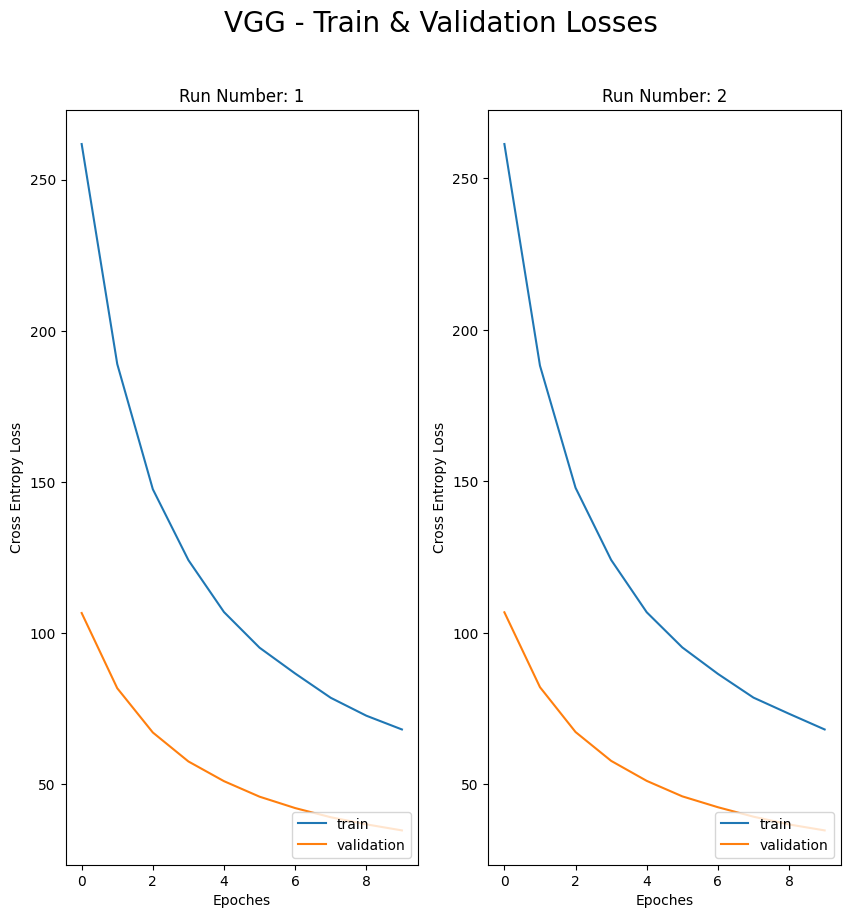

In [21]:
plot_train_validation_losses('VGG',vgg_meta)

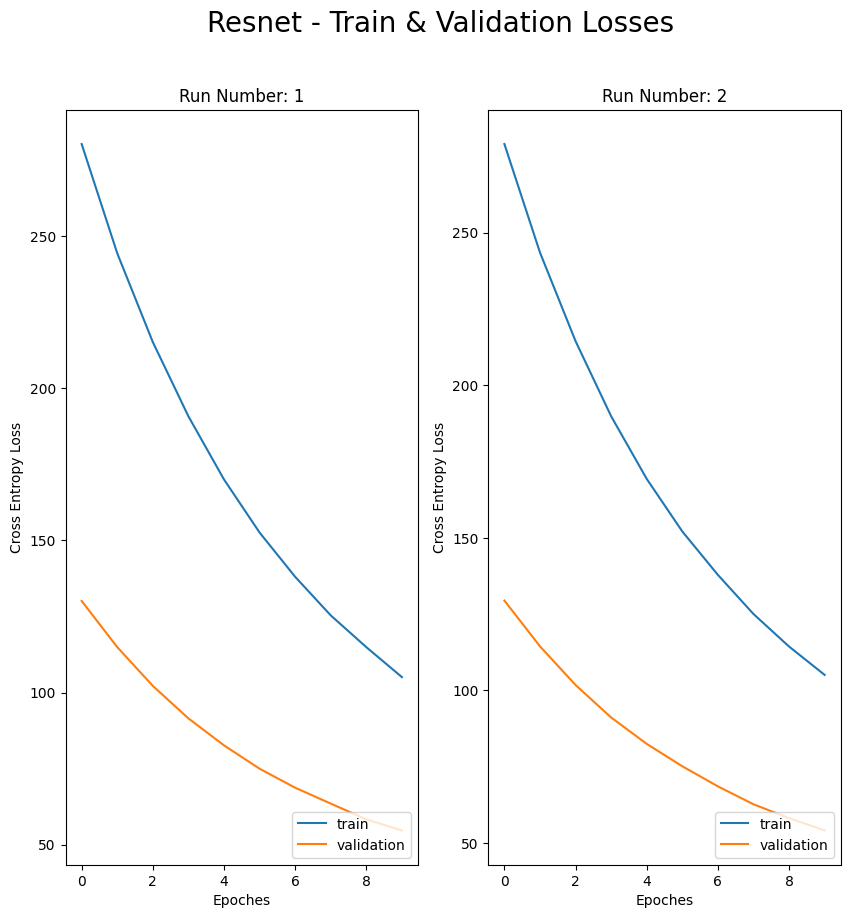

In [22]:
plot_train_validation_losses('Resnet',res_meta)

In [23]:
def plot_test_accuracy(vgg_data,alexnet_data,names=['VGG','Resnet']):

    vgg_test = np.array([data['test']['accuracy'] for data in vgg_data]).flatten()
    alexnet_test = np.array([data['test']['accuracy'] for data in alexnet_data]).flatten()
    X_axis = np.arange(len(names))
    
    plt.bar(X_axis - 0.2, vgg_test, 0.4, label = 'Run1')
    plt.bar(X_axis + 0.2, alexnet_test, 0.4, label = 'Run2')
    
    plt.xticks(X_axis, names)
    plt.xlabel("Models")
    plt.ylabel("Test Accuracy")
    plt.title("Compare Accuracy Of Both Models")
    plt.legend()
    plt.show()

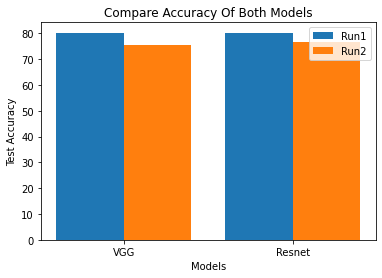

In [24]:
plot_test_accuracy(vgg_meta,res_meta)